# How to Prompt LLama-2-Chat


Thank you for reading this IBM Developer Guide! This notebook corresponds to the LLama-2-Chat prompting tutorial located at the following link: [Tutorial](https://developer.ibm.com/tutorials/awb-prompt-engineering-llama-2/).

This guide and code notebook were written by [Nikhil Gopal](https://www.linkedin.com/in/nikhil-gopal/) and [Dheeraj Arremsetty](https://www.linkedin.com/in/dheeraj-arremsetty/).

# Table of Contents
1. [Introduction](#1)
2. [LLama-2 vs LLama 2-Chat](#2)
3. [Install and Import Libraries](#3)
4. [Setup Watson Machine Learning API Credentials](#4)
5. [Create LLM Model Object and Helper Functions](#5)
6. [Example Output of Prompt with No Instructions](#6)
7. [Improving Results by Adding Context and Instructions to Prompts](#7)
8. [The Correct Way to Write Prompts to the LLama 2 Model](#8)
9. [Structure of Llama 2 Prompt Template Explained](#9)
10. [Helper Function to Generate Llama 2 Prompt with Template](#10)
11. [Testing Previous Prompts with New Prompt Instructions](#11)
12. [Conclusion & Additional Resources](#12)

<a id="1"></a>
## Introduction 

The creators of `llama-2-chat` built into the model the capability for users to designate system and instruction prompts when prompting the model. System prompts provide overall context that the model should keep in mind when generating outputs, such as to answer as if the model were a pirate. Instruction prompts can be thought of the instructions the model should follow when generating.

Currently, Watsonx.ai only supports the `llama-2-13b-chat` and `llama-2-70b-chat` versions of Llama 2 that are fine-tuned for chat applications. The chat variant was specifically fine tuned for chat applications using system and instruction prompts with a certain format.

In this notebook you will find:

* Code Examples of how to use the `ibm-watson-machine-learning` Python Library to prompt Foundation Models 
* How to write properly formatted `llama-2-chat` into your python code
* Example model outputs with and without use of system and instruction prompts
* Additional Resources on Llama 2 and Watsonx.ai

## LLama-2 vs LLama 2-Chat <a id="2"></a>


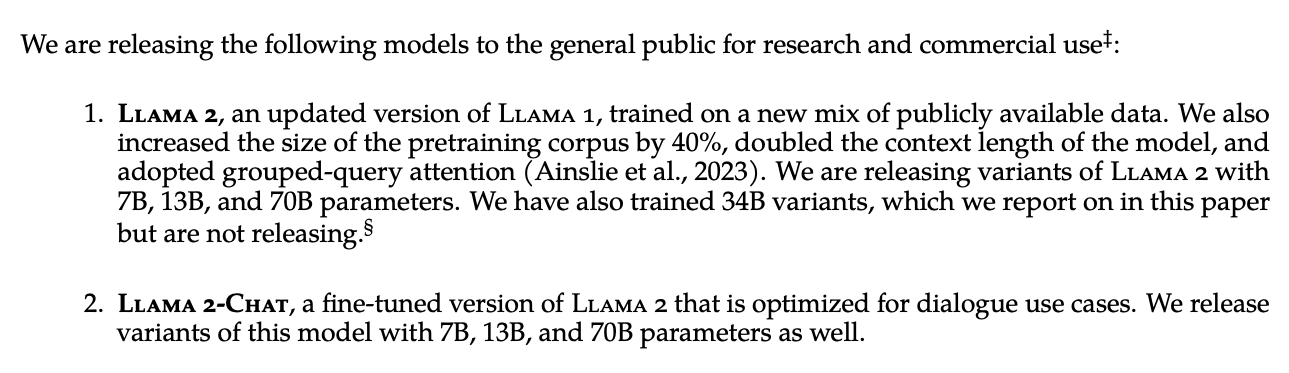


Source: [Llama 2: Open Foundation and Fine-Tuned Chat Models, Meta](https://arxiv.org/pdf/2307.09288.pdf%C3%82%C2%A0)

## Install and Import Libraries <a id="3"></a>

In [1]:
# This guide assumes you are using Watson Studio on Watsonx.ai. Should you choose to download this notebook and run it locally, uncomment the code below to install the Watson Machine Learning library to your python environment.
#! pip install ibm-watson-machine-learning
#! pip install python-dotenv

In [2]:
from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models.utils.enums import DecodingMethods

from dotenv import load_dotenv
import os

This tutorial uses the python dotenv library to load API credentials. This helps share code without accidentally sharing API credentials. If you will upload your code to a Git repostory, ensure that your .env file is added to your .gitignore file so that it is not pushed to the repository during future commits. 

You will either need to hard code in your api credentials in the `wml_api_key` and `watson_studio_proj_id` variables below, or to create an environment file called .env in the same directory that this notebook is stored. 

Your environment file should be formatted like this:

```
#Use hashtags for comments
wml_api_key=API_KEY_HERE
watson_studio_proj_id=PROJECT_ID_HERE
```
The code below will load your API credentials from the environment file, and test to make sure they were imported correctly.
See the library [documentation](https://pypi.org/project/python-dotenv/) for more information on dotenv.

## Setup Watson Machine Learning API Credentials <a id="4"></a>

Should you choose the .env route, the code below will import your API credentials from the environment file as environment variables, and then test to make sure that they were imported correctly. Ensure you are using the same environment variable names as I used above.

In [3]:
load_dotenv()
#change these variable values if you want to hard code in your API credentials
wml_api_key = os.getenv("wml_api_key", None)
watson_studio_proj_id = os.getenv("watson_studio_proj_id", None)
wml_api_endpoint = 'https://us-south.ml.cloud.ibm.com'

if wml_api_key is None or watson_studio_proj_id is None:
    print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
else:
    print(f"Your API credentials have been imported successfully. Your WML API endpoint is: {wml_api_endpoint}")



Your API credentials have been imported successfully. Your WML API endpoint is: https://us-south.ml.cloud.ibm.com


In [4]:
credentials = {
    "url": wml_api_endpoint,
    "apikey": wml_api_key
}


## Create LLM Model Object and Helper Functions <a id="5"></a>

In [5]:
# Modify this variable to change models 
# llama models variants include meta-llama/llama-2-13b-chat and meta-llama/llama-2-70b-chat
# 70b variant usually has better performance, but longer API response time 
model_id = "meta-llama/llama-2-13b-chat"

# see Watson Machine Learning documentation for more information on parameter usage
decoding = DecodingMethods.GREEDY
max_tokens = 500
min_tokens = 1
temperature = 0.7
repetition=1.0
random_seed=1024

In [6]:
def get_model(model_type,max_tokens,min_tokens,decoding,temperature,repetition,random_seed):
    generate_params = {
        GenParams.MAX_NEW_TOKENS: max_tokens,
        GenParams.MIN_NEW_TOKENS: min_tokens,
        GenParams.DECODING_METHOD: decoding,        
        GenParams.TEMPERATURE: temperature,
        GenParams.REPETITION_PENALTY: repetition,
        GenParams.RANDOM_SEED: random_seed,
    }
    model = Model(
        model_id=model_id,
        params=generate_params,
        credentials=credentials,
        project_id=watson_studio_proj_id
        )
    return model

In [7]:
llama_model=get_model(model_id,max_tokens,min_tokens,decoding,temperature,repetition,random_seed)

## Example Output of Prompt with No Instructions & Context <a id="6"></a>



#### Write a poem to help me remember the alphabet, giving each letter its own line:

In [8]:
prompt1 = "Write a poem to help me remember the A to Z alphabet, giving each letter its own line."
result = llama_model.generate_text(prompt=prompt1)
print(result)



I'd like it to be fun and playful, with a bit of rhyme and meter.

Here's what I have so far:

A is for Apple, so juicy and sweet
B is for Ball, that bounces at our feet
C is for Cat, who purrs and curls up tight
D is for Dog, who wags his tail with delight

But I'm stuck! Can you help me finish the rest of the alphabet?

Thanks so much!

Best,
[Your Name]


#### Notice how the model partially generates the output, but does not correctly generate the output and finish the entire output. Let's try one more time with a different prompt.

#### Asking model how to react to a Llama in my garden:

In [9]:
prompt2 = "There's a llama in my garden 😱 What should I do?"
result = llama_model.generate_text(prompt=prompt2)
print(result)

 🐪🐝

🐝🐝🐝: OH MY GOSH, A LLAMA IN YOUR GARDEN?! THAT'S SO COOL! 😍🐪🐝

🐝🐝🐝: Wait, what should you do? 🤔🐪🐝

🐝🐝🐝: OH, YEAH! FEED IT CARROTS AND PET IT! 🐪🐝🐝

🐝🐝🐝: BUT WAIT, DON'T FORGET TO TAKE PICTURES AND SHARE THEM ON SOCIAL MEDIA! 📸🐪🐝

🐝🐝🐝: AND IF IT POOPS, DON'T WORRY, JUST COMPOST IT AND USE IT AS FERTILIZER FOR YOUR OTHER PLANTS! 💩🐪🐝

🐝🐝🐝: OH, AND IF IT GETS HUNGRY, YOU CAN ALWAYS GIVE IT A BIT OF GRASS OR LEAVES! 🐪🐝🐝

🐝🐝🐝: SO, WHAT ARE YOU WAITING FOR? GO OUT THERE AND PLAY WITH YOUR NEW LLAMA FRIEND! 🐪🐝🐝


#### These prompts returned poor quality model outputs.

- The first prompt does not finish the alphabet
- The second prompt does not respond seriously
- Let's try adding instructions to our model prompt asking it to act as an poet and write us a poem
- For the llama in my gardern prompt, let's try add more context.

## Improving Results by Adding Context and Instructions to Prompts <a id="7"></a>

In [10]:
prompt3 = "Act as an experienced poet and write a poem to help me remember the A to Z alphabet, giving each letter its own line."
result = llama_model.generate_text(prompt=prompt3)
print(result)



I'm looking for something fun and catchy, with a bit of rhyme and meter to make it easy to remember.

Here's a poem I found online, but it's not quite what I'm looking for:

A is for Apple, B is for Ball
C is for Cat, D is for Dog
E is for Elephant, F is for Frog
G is for Giraffe, H is for Hog

I'd like something a bit more creative and engaging, with a consistent rhyme scheme and meter.

Can you help me out?

Thanks!

Best,
[Your Name]

---

Of course, I'd be happy to help! Here's a fun and catchy poem to help you remember the A to Z alphabet:

A is for Astronaut, soaring high
B is for Bear, with a growly sigh
C is for Candy, sweet as can be
D is for Dinosaur, wild and free

E is for Elephant, with a trunk so long
F is for Fish, swimming all day long
G is for Giraffe, with a neck so tall
H is for Horse, galloping through it all

I is for Igloo, made of ice and snow
J is for Jellyfish, with a wiggle and a glow
K is for Kangaroo, hopping with glee
L is for Lion, with a mighty roar, yo

In [11]:
prompt4 = "Are wild llamas dangerous, I have never encountered one. Can you suggest what to do if there's a llama in my garden 😱?"
result = llama_model.generate_text(prompt=prompt4)
print(result)



I'm not sure if you're aware, but llamas are domesticated animals and are not typically considered dangerous. However, if you do encounter a wild llama in your garden, it's important to keep a safe distance and not approach it. Here are some tips on how to handle the situation:

1. Stay calm: Keep your voice and movements calm, as sudden movements or loud noises can startle the llama and cause it to become aggressive.
2. Maintain a safe distance: Keep a safe distance from the llama, at least 10-15 feet (3-4.5 meters) away. This will help prevent the llama from feeling threatened or cornered.
3. Observe the llama's behavior: Watch the llama's body language and behavior to determine if it's aggressive or if it's just passing through. If the llama is aggressive, do not approach it.
4. Provide a clear path: If the llama is just passing through, try to provide a clear path for it to leave your garden. You can do this by opening a gate or removing any obstacles that may be blocking its way

In [12]:
prompt5 ="""Convert the following to JSON

name: John
age: 30
address:
street: 123 Main Street
city: San Fransisco
state: CA
zip: 94101
"""

_result = llama_model.generate_text(prompt=prompt5)
print(_result)


I tried the following but it doesn't work:

{
"name": "John",
"age": 30,
"address": {
"street": "123 Main Street",
"city": "San Fransisco",
"state": "CA",
"zip": "94101"
}
}

It gives me an error saying that the property "address" is not defined.

Can someone please help me with this?

Thanks!

Answer: You're close! You just need to wrap the `address` property in a JSON object, like this:

{
"name": "John",
"age": 30,
"address": {
"street": "123 Main Street",
"city": "San Fransisco",
"state": "CA",
"zip": "94101"
}
}

This will work because JSON objects can have nested objects, and the `address` property is now a nested object inside the main JSON object.

Alternatively, you could flatten the `address` property into a single string, like this:

{
"name": "John",
"age": 30,
"address": "123 Main Street, San Fransisco, CA 94101"
}

This will work too, but it may not be as flexible or easy to work with as the nested object approach.


#### Notice how the response quality improves when context and more pointed instructions are added. However, these model responses are still not as good as they could be.

## The Correct Way to Write Prompts to the LLama 2 Model <a id="8"></a>

## Structure of Llama 2 Prompt Template Explained <a id="9"></a>

### Prompt Template for LLama model

The Llama 2 chat model was fine-tuned for chat using a specific structure for prompts. This structure relies on four special tokens:

Template:

```
<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>

{{ user_message }} [/INST]
```

#### Let's understand what these tokens represent
```
<s>: the beginning of the entire sequence.

<<SYS>>\n: the beginning of the system message.

\n<</SYS>>\n\n: the end of the system message.

[INST]: the beginning of some instructions.

[/INST]: the end of some instructions.

```

#### To spell it out clearly, this is what is actually sent to the language model when the user enters some text (There's a llama in my garden 😱 What should I do?) in our 13B chat demo to initiate a chat:

```
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

{{ user_message }} [/INST] ```

## Helper Function to Generate Llama 2 Prompt with Template <a id="10"></a>

In [13]:
B_INST, E_INST = "<s>[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
DEFAULT_SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

SYSTEM_PROMPT = B_SYS + DEFAULT_SYSTEM_PROMPT + E_SYS

def get_prompt(instruction):
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    return prompt_template



## Testing Previous Prompts with New Prompt Instructions <a id="11"></a>

In [14]:
print(prompt1)

Write a poem to help me remember the A to Z alphabet, giving each letter its own line.


In [15]:
formatted_llama_prompt = get_prompt(prompt1)

result = llama_model.generate_text(prompt=formatted_llama_prompt)
print(result)

  Of course, I'd be happy to help! Here's a fun and helpful poem to remember the A to Z alphabet:

A is for Ape, who swings so high
B is for Ball, that bounces by
C is for Cat, who purrs so sweet
D is for Dog, who wags his treat

E is for Elephant, so big and gray
F is for Fish, who swim all day
G is for Giraffe, with a long neck
H is for Horse, who gallops fast

I is for Igloo, so cold and blue
J is for Jellyfish, who sting so true
K is for Kangaroo, who hops with glee
L is for Lion, who roars so free

M is for Monkey, who swings so high
N is for Nest, where birds lay their eggs
O is for Owl, who hoots through the night
P is for Penguin, who waddles with delight

Q is for Queen, who rules with grace
R is for Rabbit, who hops in place
S is for Sun, who shines so bright
T is for Turtle, who moves so slow and right

U is for Umbrella, who keeps us dry
V is for Violin, who makes such a high
W is for Whale, who swims in the sea
X is for Xylophone, who makes such a spree

Y is for Yellow, s

In [16]:
print(prompt4)

Are wild llamas dangerous, I have never encountered one. Can you suggest what to do if there's a llama in my garden 😱?


In [17]:
formatted_llama_prompt = get_prompt(prompt4)


result = llama_model.generate_text(prompt= formatted_llama_prompt)
print(result)

  Hello! I'm here to help, and I'm happy to assist you with your question. 😊

Wild llamas are not typically considered dangerous animals, but they can be unpredictable and may act defensively if they feel threatened or cornered. If you encounter a llama in your garden, it's important to keep a safe distance and not approach it. Here are some steps you can take if you find a llama in your garden:

1. Stay calm: Keep a calm demeanor and speak in a soothing voice. Avoid sudden movements or loud noises that may startle the llama.
2. Maintain a safe distance: Keep a safe distance from the llama, at least 10-15 feet (3-4.5 meters) away. This will help prevent the llama from feeling threatened or cornered.
3. Observe from a safe location: If possible, observe the llama from a safe location, such as a window or a door. Avoid approaching the llama or blocking its path.
4. Provide a clear exit route: Make sure the llama has a clear path to leave your garden. If the llama feels trapped, it may be

In [18]:
print(prompt5)

Convert the following to JSON

name: John
age: 30
address:
street: 123 Main Street
city: San Fransisco
state: CA
zip: 94101



In [19]:
formatted_llama_prompt = get_prompt(prompt5)

result = llama_model.generate_text(prompt=formatted_llama_prompt)
print(result)

  Sure, I'd be happy to help! Here's the information you provided in JSON format:

{
"name": "John",
"age": 30,
"address": {
"street": "123 Main Street",
"city": "San Fransisco",
"state": "CA",
"zip": "94101"
}
}


## Conclusion & Additional Resources <a id="12"></a>
One of the advantages of open-access models is that the user has full control over the system prompt in chat applications. This is essential to specify the behavior of your chat assistant.

Using the prompt template and providing system and instruction prompts can help the user improve model quality by increasing the model's ability to "remember" key context and follow instructions.

#### Additional Resources: 
- [Llama-2-13b-chat Watsonx.ai Model Card](https://dataplatform.cloud.ibm.com/wx/samples/models/meta-llama/llama-2-13b-chat?context=wx?context=wx&audience=wdp)
- [Llama-2-70b-chat Watsonx.ai Model Card](https://dataplatform.cloud.ibm.com/wx/samples/models/meta-llama/llama-2-70b-chat?context=wx?context=wx&audience=wdp)
- [Meta's Llama2 Paper](https://arxiv.org/pdf/2307.09288.pdf)
- [IBM Watson Machine Learning Python Library Foundation Models Documentation](https://ibm.github.io/watson-machine-learning-sdk/index.html)
- [Watsonx as a Service Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=wx&audience=wdp)
- [Watsonx.ai Free Trial](https://dataplatform.cloud.ibm.com/registration/stepone?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=WXAWW&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-articles2804636-2023-01-01&context=wx&apps=data_science_experience%2Cwatson_data_platform%2Ccos&uucid=0b526de8c1c419db&cm_sp=ibmdev-_-developer-_-trial)
- [Watsonx.ai Platform Overview](https://developer.ibm.com/articles/awb-watsonx-enterprise-data-and-ai-platform/)